# Movie recommendation using ALS in Spark

The goal of this project is to use Alternating Least Squares (ALS) in Spark to recommend movies.

# Set-up

## Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [2]:
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# Create a spark context and session
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar -xzf '/content/drive/MyDrive/Colab Notebooks/spark-3.0.1-bin-hadoop2.7.tgz'
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
%cd /content

import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext.getOrCreate()
spark = pyspark.sql.SparkSession.builder.getOrCreate()
print(sc)
print(spark)

/root
/content
<SparkContext master=local[*] appName=pyspark-shell>


# Background (placeholder)
* Recommendation systems
* Collaborative filtering
* ALS matrix factorization


# Local training
Before training a model in the cloud, a smaller model will be trained locally using PySpark. This will enable validation of the approach.

## Training/test data

**Key observations:**

* The dataset consists of 1501 records.

* It contains the following four columns: 'userID', 'movieID', 'rating' and 'timestamp'. These are seperated by '::'

* Two Spark DataFrames are created. These correspond to training/test data

  Note: Data is read into an RDD initially.

In [59]:
!wc "/content/drive/MyDrive/Colab Notebooks/sample_movielens_ratings.txt"
print("\n")
!head -n 5 "/content/drive/MyDrive/Colab Notebooks/sample_movielens_ratings.txt"

 1501  1501 32363 /content/drive/MyDrive/Colab Notebooks/sample_movielens_ratings.txt


0::2::3::1424380312
0::3::1::1424380312
0::5::2::1424380312
0::9::4::1424380312
0::11::1::1424380312


In [60]:
# Read into RDD
records = spark.read.text("/content/drive/MyDrive/Colab Notebooks/sample_movielens_ratings.txt").rdd
display(records.take(1))

# Split columns
elements = records.map(lambda row: row.value.split('::'))
print("\n")
display(elements.take(1))

[Row(value='0::2::3::1424380312')]

[['0', '2', '3', '1424380312']]

In [57]:
# Create DataFrame using pyspark.sql.Row object
from pyspark.sql import Row
row_RDD = elements.map(lambda row: Row(userId=int(row[0]), movieId=int(row[1]), rating=float(row[2]), timestamp=int(row[3])))
ratings_DF = spark.createDataFrame(row_RDD)
ratings_DF.createOrReplaceTempView('ratings_DF') # register temporary view enabling SQL queries

# Train/test split
(training_DF, valid_DF) = ratings_DF.randomSplit([0.8, 0.2])
print("Training data:")
print(training_DF.show(5))
print(training_DF.count())
print("\nTest data:")
print(valid_DF.show(5))
print(valid_DF.count())

Training data:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|      2|   3.0|1424380312|
|     0|      3|   1.0|1424380312|
|     0|      5|   2.0|1424380312|
|     0|      9|   4.0|1424380312|
|     0|     11|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

None
1199

Test data:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     0|     12|   2.0|1424380312|
|     0|     17|   1.0|1424380312|
|     0|     28|   1.0|1424380312|
|     0|     34|   1.0|1424380312|
|     0|     55|   1.0|1424380312|
+------+-------+------+----------+
only showing top 5 rows

None
302


## Baseline

**Key observation:**
* A naive prediction will be used to construct a baseline model. This will be the mean rating across all movies.

* The performance of this baseline model is estimated using root-mean-squared error.

In [10]:
# Naive prediction
SQL_query = 'SELECT AVG(rating) FROM ratings_DF'
row_baseline = spark.sql(SQL_query).collect()[0] # query returns dataframe with only 1 row
naive_pred = row_baseline['avg(rating)'] # access via dictionary
print(naive_pred)

1.7741505662891406


In [61]:
# Squared error for each movie
se_RDD = valid_DF.rdd.map(lambda row: Row(se=pow(row['rating']-baseline, 2)))
se_DF = spark.createDataFrame(se_RDD)
se_DF.createOrReplaceTempView('se_DF') # register temporary view enabling SQL queries
se_DF.show(5)

# RMSE
SQL_query = 'SELECT AVG(se) FROM se_DF'
row_avg = spark.sql(SQL_query).collect()[0] # query returns dataframe with only 1 row
MSE = row_avg['avg(se)'] # access via dictionary
print(f"Baseline RMSE: {sqrt(MSE)}")

+-------------------+
|                 se|
+-------------------+
|0.05100796670751588|
|  0.599309099285797|
|  0.599309099285797|
|  0.599309099285797|
|  0.599309099285797|
+-------------------+
only showing top 5 rows

Baseline RMSE: 1.1547772862586039


## Hyperparameter tuning

**Key observations:**

* An [ALS estimator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html#pyspark.ml.recommendation.ALS) is created and cross-validation is used to assess different values for 'rank' and 'regParam'.

  Where, 'rank' is the number of latent factors in the model and 'regParam' is the coefficient of the regularisation term.

* By default, the CrossValidator returns the model with the highest average cross-validation metric across folds.

* Root-mean-squared-error was used to evaluate performance.

In [29]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# ALS estimator
als = ALS(maxIter=10, rank=15, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating")

# Parameter grid
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html#pyspark.ml.tuning.ParamGridBuilder
param_grid = ParamGridBuilder().addGrid(als.rank, [15, 20, 25]).addGrid(als.regParam, [0.01, 0.1, 1, 10]).build()

# Regression evaluator
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# k-fold cross validation
# Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
k=3
kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=k)
cvModel = kfold_cv.fit(training_DF)

In [30]:
# Gridsearch results
# Note: Parameter maps and metrics are local Python lists hence pandas dataframe
cv_output = list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))
cv_output = pd.DataFrame(cv_output, columns=['parameter combination', 'rmse'])
cv_output.sort_values(by=['rmse']).head()

,parameter combination,rmse
5,"{ALS_92bb8309cc73__rank: 20, ALS_92bb8309cc73_...",1.117973
1,"{ALS_92bb8309cc73__rank: 15, ALS_92bb8309cc73_...",1.118259
9,"{ALS_92bb8309cc73__rank: 25, ALS_92bb8309cc73_...",1.118272
6,"{ALS_92bb8309cc73__rank: 20, ALS_92bb8309cc73_...",1.516239
2,"{ALS_92bb8309cc73__rank: 15, ALS_92bb8309cc73_...",1.516239


In [31]:
# Optimal configuration
print(f"Lowest RMSE: {cv_output.iloc[cv_output['rmse'].idxmin(), 1]}")
print('Congiguration: ')
display(cv_output.iloc[cv_output['rmse'].idxmin(), 0])

Lowest RMSE: 1.1179729833114735
Congiguration: 


{Param(parent='ALS_92bb8309cc73', name='rank', doc='rank of the factorization'): 20,
 Param(parent='ALS_92bb8309cc73', name='regParam', doc='regularization parameter (>= 0).'): 0.1}

## Model retraining
**Key observations:**

* The model is retrained using all the training data and the optimal hyperparameter configuration.

In [ ]:
als = ALS(maxIter=10, rank=20, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating")
local_model = als.fit(training_DF)

In [100]:
print(f"Factorized user matrix (rank: {local_model.rank})")
local_model.userFactors.show(5, truncate=False)
print("_"*50, "\n"*2)
print(f"Factorized item matrix (rank: {local_model.rank})")
local_model.itemFactors.show(5, truncate=False)

Factorized user matrix (rank: 20)
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                                                                                 |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0  |[-0.4921751, -0.42428914, -0.58247656, -0.04938016, 0.1075333, -0.0021624768, 0.18210033, 0.60748225, 0.047875714, 0.22440933, 0.1632907, 0.15016097, 0.052175052, -0.3218436, 0.017567582, -0.28

In [104]:
k = 5
print(f"Recommended top {k} users by movie with the corresponding predicted ratings:")
local_model.recommendForAllItems(k).show(5, truncate=False)
print("_"*50, "\n"*2)
print(f"Recommended top {k} movies by user with the corresponding predicted ratings:")
local_model.recommendForAllUsers(k).show(5, truncate=False)

Recommended top 5 users by movie with the corresponding predicted ratings:
+-------+-------------------------------------------------------------------------------------+
|movieId|recommendations                                                                      |
+-------+-------------------------------------------------------------------------------------+
|31     |[[12, 2.9682949], [8, 2.7922924], [7, 2.5502038], [14, 2.4726067], [6, 2.2745883]]   |
|85     |[[8, 4.160405], [7, 3.3034482], [14, 2.9929502], [6, 2.9518063], [21, 2.9409647]]    |
|65     |[[23, 4.1850834], [12, 3.2609832], [29, 2.8855283], [11, 2.8174825], [17, 2.7475526]]|
|53     |[[8, 4.4368887], [21, 4.2494946], [22, 3.2436292], [4, 3.062042], [14, 3.0533252]]   |
|78     |[[26, 1.080293], [22, 1.0593016], [2, 1.0528979], [11, 1.0088326], [23, 1.0013069]]  |
+-------+-------------------------------------------------------------------------------------+
only showing top 5 rows

____________________________________

## Evaluation

**Key observations:**

* The retrained model is assessed using the test set. It performs better than the baseline model.

* Plotting actual rating versus predicted rating shows a positive correlation. However, variance is high across the full range of ratings. This may be due to the small size of the training set.

In [105]:
valid_pred = local_model.transform(valid_DF)
reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = reg_eval.evaluate(valid_pred)

print(f"RMSE: {rmse}")
print("_"*50, "\n"*2)
valid_pred.show()

RMSE: 0.9750150456757296
__________________________________________________ 


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     5|     31|   1.0|1424380312| 1.1695557|
|     4|     31|   1.0|1424380312| 1.4681472|
|    28|     85|   1.0|1424380312| 1.2729641|
|    26|     85|   1.0|1424380312| 0.9545313|
|    13|     85|   1.0|1424380312| 1.4464704|
|    16|     85|   5.0|1424380312| 2.1408818|
|    20|     85|   2.0|1424380312| 1.8305455|
|    15|     85|   1.0|1424380312| 1.0068299|
|    19|     65|   1.0|1424380312| 1.0864954|
|    12|     53|   1.0|1424380312| 1.0321212|
|     6|     53|   1.0|1424380312| 1.8331316|
|    23|     53|   1.0|1424380312|0.39603585|
|    19|     78|   1.0|1424380312| 0.7281174|
|    24|     78|   1.0|1424380312| 0.9074033|
|     0|     34|   1.0|1424380312| 0.9669715|
|    22|     81|   1.0|1424380312|  1.811269|
|     1|     81|   1.0|1424380312| 1.4099746|
|

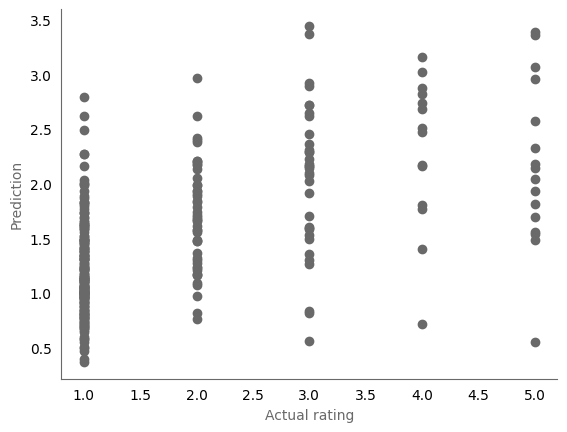

In [118]:
local_model = valid_pred.toPandas()

fig, axes = plt.subplots()
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

axes.scatter(local_model['rating'], local_model['prediction'], color='dimgray')
axes.set_xlabel('Actual rating', fontsize=10, color='dimgray')
axes.set_ylabel('Prediction', fontsize=10, color='dimgray');

## User recommendation
**Key observations:**
* Recommendations are made by making predictions for all movies in the test data (followed by sorting).

  Note: There is no overlap between the ratings history for a user, as given in the training data, and the shortlist of movies in the test data.

In [80]:
# Ratings history in the training data
USER_ID = 11
user_history = training_DF.filter(training_DF['userId']==USER_ID)
user_history.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|    11|      6|   2.0|1424380312|
|    11|      9|   1.0|1424380312|
|    11|     10|   1.0|1424380312|
|    11|     11|   1.0|1424380312|
|    11|     12|   1.0|1424380312|
|    11|     13|   4.0|1424380312|
|    11|     16|   1.0|1424380312|
|    11|     18|   5.0|1424380312|
|    11|     19|   4.0|1424380312|
|    11|     20|   1.0|1424380312|
+------+-------+------+----------+
only showing top 10 rows



In [82]:
# Recommendations from the test data
print(f"Shortlist of movies in the test data:")
user_shortlist = valid_DF.filter(valid_DF['userId']==USER_ID).select(['movieId', 'userId'])
user_shortlist.show()

print(f"Top 5 recommendations:")
user_recommend = local_model.transform(user_shortlist)
user_recommend.orderBy('prediction', ascending=False).show(5)

Shortlist of movies in the test data:
+-------+------+
|movieId|userId|
+-------+------+
|      0|    11|
|     36|    11|
|     41|    11|
|     43|    11|
|     48|    11|
|     61|    11|
|     67|    11|
|     70|    11|
|     71|    11|
|     72|    11|
|     76|    11|
|     77|    11|
|     86|    11|
+-------+------+

Top 5 recommendations:
+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|     76|    11| 2.6217453|
|     36|    11| 2.2006466|
|     72|    11| 2.1804938|
|     43|    11| 2.0464292|
|     77|    11| 1.7649262|
+-------+------+----------+
only showing top 5 rows



# Cloud training
**Key observation:**
* The final model will be trained using all available data. This will be achieved using the Google Cloud platform.

## Data
**Key observation:**
* The data is available in csv form. Consequently, the data prep process will need to be adjusted.

In [ ]:
!wc "/content/drive/MyDrive/Colab Notebooks/ratings.csv"

 100837  100837 2483723 /content/drive/MyDrive/Colab Notebooks/ratings.csv


In [ ]:
!head -n 5 "/content/drive/MyDrive/Colab Notebooks/ratings.csv"

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815


## Training script

In [ ]:
%%writefile als_model.py
import sys
from math import sqrt
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

INPUT_PATH = sys.argv[1] # parse file path from command line

if __name__ == '__main__':

    # Create SparkContext and SparkSession
    sc = SparkContext(appName="spark-submit demo")
    spark = SparkSession.builder.getOrCreate()

    # 1. Training/test data prep
    rows = spark.read.csv(INPUT_PATH, header=True).rdd
    row_RDD = rows.map(lambda row: Row(userId=int(row[0]), movieId=int(row[1]), rating=float(row[2]), timestamp=int(row[3])))
    ratings_DF = spark.createDataFrame(row_RDD)
    ratings_DF.createOrReplaceTempView('ratings_DF') # register temporary view enabling SQL queries
    (training_DF, test_DF) = ratings_DF.randomSplit([0.8, 0.2])

    # 2. Baseline
    # Calculate mean rating across all rows in the training set
    SQL_query = 'SELECT AVG(rating) FROM ratings_DF'
    row_baseline = spark.sql(SQL_query).first() # query returns dataframe with only 1 row
    baseline = row_baseline['avg(rating)'] # access via dictionary

    # Calculate squared error for each row in the validation set
    se_RDD = valid_DF.rdd.map(lambda row: Row(se=pow(row['rating']-baseline, 2)))
    se_DF = spark.createDataFrame(se_RDD)
    se_DF.createOrReplaceTempView('se_DF') # register temporary view enabling SQL queries

    # Calculate RMSE
    SQL_query = 'SELECT AVG(se) FROM se_DF'
    row_avg = spark.sql(SQL_query).first() # query returns dataframe with only 1 row
    MSE = row_avg['avg(se)'] # access via dictionary
    print(f"Baseline RMSE: {sqrt(MSE)}")

    # 3. Hyperparameter tuning
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html#pyspark.ml.tuning.ParamGridBuilder
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html#pyspark.ml.evaluation.RegressionEvaluator
    # Source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html

    als = ALS(maxIter=5, rank=5, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating") # ALS estimator
    param_grid = ParamGridBuilder().addGrid(als.rank, [1, 3, 10]).addGrid(als.regParam, [0.01, 0.03, 0.1, 0.3, 1]).build() # parameter grid
    reg_eval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") # regression evaluator
    k=3
    kfold_cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=reg_eval, numFolds=k) # k-fold cross validation
    cvModel = kfold_cv.fit(training_DF)

    # 4. Evaluation
    param_map = zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics)
    param_min = min(paramMap, key=lambda x: x[1])
    print(f"Optimal configuration: {param_min}")
    test_pred = cvModel.transform(test_DF)
    rmse = regEval.evaluate(test_pred)
    print(f"RMSE: {rmse}")

    # Shutdown Spark context
    sc.stop()

## Google Cloud

### Authentication

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

### Project configuration

In [ ]:
PROJECT = 'bd-lab-6-test' # Project ID
!gcloud config set project $PROJECT
REGION = 'us-central1'
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!echo "gcloud config list"
!gcloud config list # show some information

### Data upload

In [ ]:
# Create storage bucket
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET
print(BUCKET)

In [ ]:
# Copy data to storage bucket
FILEPATH = "/content/drive/MyDrive/Colab Notebooks/ratings.csv"
!gsutil -m cp $FILEPATH $BUCKET
BUCKET_PATH = BUCKET+'/ratings.csv'
print(BUCKET_PATH)

### Cluster creation
Note:
* Creating the cluster can take a while. You can stop the execution of this cell and the process will still continue in the cloud. Have a look at the Cloud console to see your cluster being provisioned.

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s

### Job submission

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER ./als_model.py -- $BUCKET_PATH